In [153]:
# import libraries
import numpy as np
import pandas as pd

import matplotlib as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb

from sklearn.model_selection import train_test_split
import time

# Data Exploration

Load data.

In [33]:
file_path = '../raw_data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv'
df = pd.read_csv(file_path, parse_dates = ['month'])

Inspect data.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157097 entries, 0 to 157096
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   month                157097 non-null  datetime64[ns]
 1   town                 157097 non-null  object        
 2   flat_type            157097 non-null  object        
 3   block                157097 non-null  object        
 4   street_name          157097 non-null  object        
 5   storey_range         157097 non-null  object        
 6   floor_area_sqm       157097 non-null  float64       
 7   flat_model           157097 non-null  object        
 8   lease_commence_date  157097 non-null  int64         
 9   remaining_lease      157097 non-null  object        
 10  resale_price         157097 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 13.2+ MB


In [35]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [9]:
df.isnull().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
floor_area_sqm,157097.0,97.471023,24.041369,31.0,82.0,94.0,113.0,249.0
lease_commence_date,157097.0,1995.686124,13.834514,1966.0,1985.0,1996.0,2008.0,2019.0
resale_price,157097.0,484351.588099,167452.794849,140000.0,360000.0,453000.0,575000.0,1500000.0


# Data Cleaning/Feature Engineering

### Converting storey range from string to integer

In [13]:
df['storey_range'].unique()

array(['10 TO 12', '01 TO 03', '04 TO 06', '07 TO 09', '13 TO 15',
       '19 TO 21', '22 TO 24', '16 TO 18', '34 TO 36', '28 TO 30',
       '37 TO 39', '49 TO 51', '25 TO 27', '40 TO 42', '31 TO 33',
       '46 TO 48', '43 TO 45'], dtype=object)

In [50]:
df['storey_range_low'] = df['storey_range'].str[:2].apply(lambda x: int(x))
df['storey_range_high'] = df['storey_range'].str[-2:].apply(lambda x: int(x))

In [53]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,storey_range_low,storey_range_high
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,10,12
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,1,3
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,1,3
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,4,6
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,1,3


### Converting remaining lease from string to float

In [71]:
df['remaining_lease_years'] = df['remaining_lease'].str[:2].apply(lambda x: int(x))
df['remaining_lease_months'] = df['remaining_lease'].str[9:11]


In [74]:
# check for errors
df[df['remaining_lease_months'] == '']

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,storey_range_low,storey_range_high,remaining_lease_years,remaining_lease_months
5,2017-01-01,ANG MO KIO,3 ROOM,150,ANG MO KIO AVE 5,01 TO 03,68.0,New Generation,1981,63 years,275000.0,1,3,63,
15,2017-01-01,ANG MO KIO,3 ROOM,230,ANG MO KIO AVE 3,04 TO 06,67.0,New Generation,1978,60 years,298000.0,4,6,60,
18,2017-01-01,ANG MO KIO,3 ROOM,441,ANG MO KIO AVE 10,07 TO 09,67.0,New Generation,1979,61 years,306000.0,7,9,61,
22,2017-01-01,ANG MO KIO,3 ROOM,432,ANG MO KIO AVE 10,10 TO 12,67.0,New Generation,1979,61 years,325000.0,10,12,61,
26,2017-01-01,ANG MO KIO,3 ROOM,333,ANG MO KIO AVE 1,07 TO 09,68.0,New Generation,1981,63 years,330000.0,7,9,63,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157022,2023-07-01,WOODLANDS,5 ROOM,782B,WOODLANDS CRES,10 TO 12,112.0,Improved,2015,91 years,618000.0,10,12,91,
157033,2023-07-01,WOODLANDS,5 ROOM,691C,WOODLANDS DR 73,01 TO 03,113.0,Improved,2018,94 years,638000.0,1,3,94,
157041,2023-07-01,WOODLANDS,EXECUTIVE,650,WOODLANDS RING RD,01 TO 03,141.0,Maisonette,1998,74 years,758000.0,1,3,74,
157069,2023-07-01,YISHUN,4 ROOM,259,YISHUN ST 22,10 TO 12,84.0,Simplified,1986,62 years,410000.0,10,12,62,


In [73]:
df['remaining_lease_months'].unique()#.apply(lambda x: int(x))

array(['04', '07', '05', '01', '', '06', '08', '10', '03', '09', '11',
       '02', '0 '], dtype=object)

In [79]:
df['remaining_lease_months'] = df['remaining_lease_months'].apply(lambda x: 0 if x == '0 ' or x =='' else x)
df['remaining_lease_months'] = df['remaining_lease_months'].apply(lambda x: int(x))

In [89]:
df['remaining_lease_years'] = df['remaining_lease_years'] + df['remaining_lease_months'].apply(lambda x: x/12)

In [98]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,storey_range_low,storey_range_high,remaining_lease_years,remaining_lease_months
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,10,12,61.333333,4
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,1,3,60.583333,7
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,1,3,62.416667,5
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,4,6,62.083333,1
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,1,3,62.416667,5


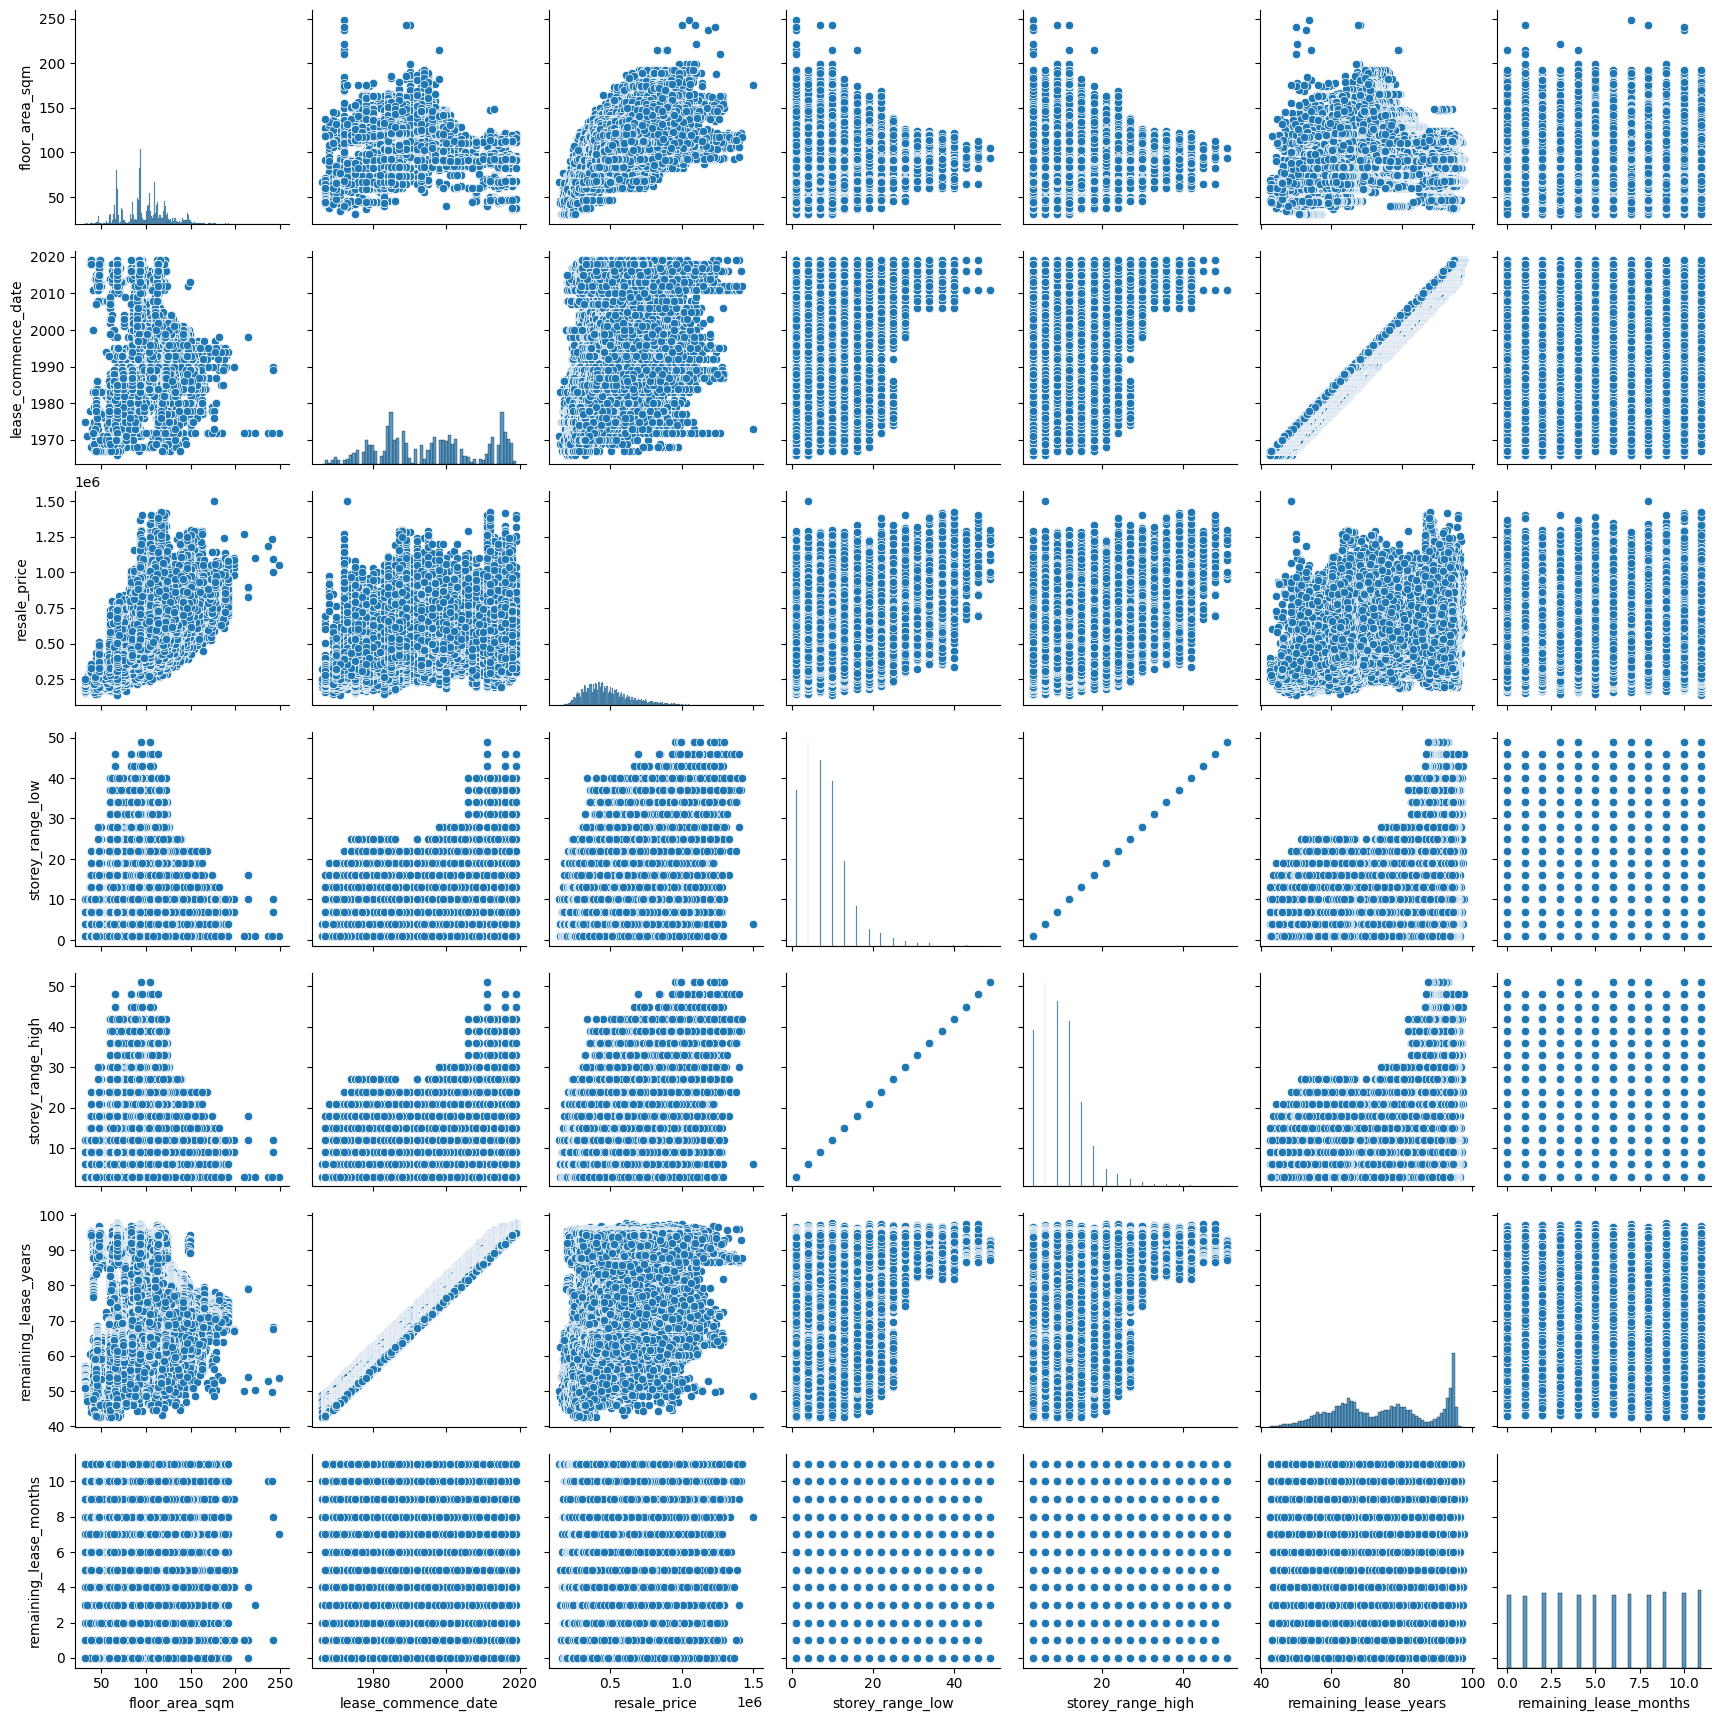

In [93]:
sns.pairplot(df)

### One Hot Encode features / Preprocessing

In [42]:
df['flat_type'].unique()

array(['2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', '1 ROOM',
       'MULTI-GENERATION'], dtype=object)

In [102]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,storey_range_low,storey_range_high,remaining_lease_years,remaining_lease_months
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,10,12,61.333333,4
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,1,3,60.583333,7
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,1,3,62.416667,5
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,4,6,62.083333,1
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,1,3,62.416667,5


In [104]:
X = df[['month', 'town', 'flat_type', 'floor_area_sqm', 'flat_model', 'remaining_lease_years', 'storey_range_low']]
y = df['resale_price']

In [105]:
X.dtypes

month                    datetime64[ns]
town                             object
flat_type                        object
floor_area_sqm                  float64
flat_model                       object
remaining_lease_years           float64
storey_range_low                  int64
dtype: object

In [106]:
numerical_features = X.select_dtypes(include=['float', 'int']).columns
categorical_features = X.select_dtypes(include='object').columns

In [131]:
numerical_pipe = make_pipeline(StandardScaler())
categorical_pipe = make_pipeline(OneHotEncoder(drop = 'if_binary', sparse = False))

features_preprocessor = make_column_transformer(
    (numerical_pipe, numerical_features),
    (categorical_pipe, categorical_features)
    )

features_preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['floor_area_sqm', 'remaining_lease_years', 'storey_range_low'], dtype='object')),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 Index(['town', 'flat_type', 'flat_model'], dtype='object'))])

In [195]:
features_preprocessor.named_transformers_['pipeline-2'].get_feature_names_out().shape


(54,)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

In [133]:
X_train_transformed = features_preprocessor.fit_transform(X_train)

In [134]:
X_train

,month,town,flat_type,floor_area_sqm,flat_model,remaining_lease_years,storey_range_low
109565,2021-12-01,SENGKANG,4 ROOM,92.0,Model A,92.666667,7
19681,2017-12-01,KALLANG/WHAMPOA,3 ROOM,71.0,Improved,53.083333,4
45593,2019-03-01,HOUGANG,4 ROOM,92.0,Model A,95.166667,13
65791,2020-01-01,TAMPINES,EXECUTIVE,142.0,Apartment,67.166667,7
9002,2017-06-01,PUNGGOL,4 ROOM,92.0,Model A,94.250000,7
...,...,...,...,...,...,...,...
97639,2021-05-01,HOUGANG,4 ROOM,89.0,Simplified,64.166667,7
95939,2021-04-01,CLEMENTI,4 ROOM,81.0,DBSS,92.833333,10
152315,2023-05-01,ANG MO KIO,4 ROOM,91.0,New Generation,56.916667,1
117952,2022-01-01,PASIR RIS,5 ROOM,126.0,Improved,70.750000,7


In [136]:
X_train_transformed.shape

(109967, 57)

# Model

In [137]:
X_test_transformed = features_preprocessor.transform(X_test)

In [154]:
model_lr = LinearRegression()
model_rf = RandomForestRegressor()
model_lgbm = lgb.LGBMRegressor()
model_dt = DecisionTreeRegressor()

In [155]:
model_list = [model_lr, model_rf, model_lgbm, model_dt]
model_names = ['model_lr', 'model_rf', 'model_lgbm', 'model_dt']

In [156]:
model_performance = dict()

for model, model_name in zip(model_list, model_names):
    print(model_name)
    starttime = time.time()
    model.fit(X_train_transformed, y_train)
    endtime = time.time()
    print(f"fit time = {endtime - starttime}")
    # y_pred = model.predict(X_test_transformed)
    
    starttime = time.time()
    score = model.score(X_test_transformed, y_test)
    endtime = time.time()
    print(f"prediction time = {endtime - starttime}")
    print('\n')
    # print(f"model score = {score}")
    
    model_performance[model_name] = score
    
model_performance

model_lr
fit time = 0.28362417221069336
prediction time = 0.028408050537109375


model_rf
fit time = 36.10030007362366
prediction time = 1.2937414646148682


model_lgbm
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 109967, number of used features: 54
[LightGBM] [Info] Start training from score 484073.404107
fit time = 0.20046210289001465
prediction time = 0.05193018913269043


model_dt
fit time = 0.6049323081970215
prediction time = 0.015849590301513672




{'model_lr': 0.7774686945915948,
 'model_rf': 0.9127363062404867,
 'model_lgbm': 0.8774552705069276,
 'model_dt': 0.865574200987482}

In [196]:
transformed_numerical_features = features_preprocessor.transformers_[0][2]
transformed_categorical_features = features_preprocessor.transformers_[1][1]['onehotencoder'].get_feature_names_out(
    features_preprocessor.transformers_[1][2]
)

In [198]:
transformed_categorical_features

array(['town_ANG MO KIO', 'town_BEDOK', 'town_BISHAN', 'town_BUKIT BATOK',
       'town_BUKIT MERAH', 'town_BUKIT PANJANG', 'town_BUKIT TIMAH',
       'town_CENTRAL AREA', 'town_CHOA CHU KANG', 'town_CLEMENTI',
       'town_GEYLANG', 'town_HOUGANG', 'town_JURONG EAST',
       'town_JURONG WEST', 'town_KALLANG/WHAMPOA', 'town_MARINE PARADE',
       'town_PASIR RIS', 'town_PUNGGOL', 'town_QUEENSTOWN',
       'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN',
       'flat_type_1 ROOM', 'flat_type_2 ROOM', 'flat_type_3 ROOM',
       'flat_type_4 ROOM', 'flat_type_5 ROOM', 'flat_type_EXECUTIVE',
       'flat_type_MULTI-GENERATION', 'flat_model_2-room',
       'flat_model_3Gen', 'flat_model_Adjoined flat',
       'flat_model_Apartment', 'flat_model_DBSS', 'flat_model_Improved',
       'flat_model_Improved-Maisonette', 'flat_model_Maisonette',
       'flat_model_Model A', 'flat_model_Model A-Maisonette',
       'flat

In [199]:
transformed_feature_names = list(transformed_numerical_features) + list(transformed_categorical_features)

In [200]:
transformed_feature_names

['floor_area_sqm',
 'remaining_lease_years',
 'storey_range_low',
 'town_ANG MO KIO',
 'town_BEDOK',
 'town_BISHAN',
 'town_BUKIT BATOK',
 'town_BUKIT MERAH',
 'town_BUKIT PANJANG',
 'town_BUKIT TIMAH',
 'town_CENTRAL AREA',
 'town_CHOA CHU KANG',
 'town_CLEMENTI',
 'town_GEYLANG',
 'town_HOUGANG',
 'town_JURONG EAST',
 'town_JURONG WEST',
 'town_KALLANG/WHAMPOA',
 'town_MARINE PARADE',
 'town_PASIR RIS',
 'town_PUNGGOL',
 'town_QUEENSTOWN',
 'town_SEMBAWANG',
 'town_SENGKANG',
 'town_SERANGOON',
 'town_TAMPINES',
 'town_TOA PAYOH',
 'town_WOODLANDS',
 'town_YISHUN',
 'flat_type_1 ROOM',
 'flat_type_2 ROOM',
 'flat_type_3 ROOM',
 'flat_type_4 ROOM',
 'flat_type_5 ROOM',
 'flat_type_EXECUTIVE',
 'flat_type_MULTI-GENERATION',
 'flat_model_2-room',
 'flat_model_3Gen',
 'flat_model_Adjoined flat',
 'flat_model_Apartment',
 'flat_model_DBSS',
 'flat_model_Improved',
 'flat_model_Improved-Maisonette',
 'flat_model_Maisonette',
 'flat_model_Model A',
 'flat_model_Model A-Maisonette',
 'flat_m

In [202]:
feature_importances = model_rf.feature_importances_

# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': feature_importances})

# Sort the features by importance (descending order)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance DataFrame
print(feature_importance_df)


                              Feature  Importance
0                      floor_area_sqm    0.440249
1               remaining_lease_years    0.151785
2                    storey_range_low    0.108892
7                    town_BUKIT MERAH    0.031404
21                    town_QUEENSTOWN    0.022731
40                    flat_model_DBSS    0.022142
5                         town_BISHAN    0.018146
32                   flat_type_4 ROOM    0.017091
17               town_KALLANG/WHAMPOA    0.014147
23                      town_SENGKANG    0.013385
10                  town_CENTRAL AREA    0.013157
26                     town_TOA PAYOH    0.011353
27                     town_WOODLANDS    0.010572
13                       town_GEYLANG    0.010280
8                  town_BUKIT PANJANG    0.008236
3                     town_ANG MO KIO    0.007618
11                 town_CHOA CHU KANG    0.007528
16                   town_JURONG WEST    0.007006
12                      town_CLEMENTI    0.006969


In [212]:
model_rf2 = RandomForestRegressor(oob_score = True, n_estimators = 100)

In [215]:
model_rf2.fit(X_train_transformed, y_train)
score = model_rf2.score(X_test_transformed, y_test)
print(f"model score = {score}")

model score = 0.9126080629410169


In [216]:
model_rf2.oob_score_

0.909858865019191

In [217]:
X_train.columns

Index(['month', 'town', 'flat_type', 'floor_area_sqm', 'flat_model',
       'remaining_lease_years', 'storey_range_low'],
      dtype='object')